In [1]:
import numpy as np
import time
import pandas as pd
from scipy.sparse import csr_matrix
from netreco import Reconstructor, ss_sim
from netreco.Reconstructor import Profile
import matplotlib.pyplot as plt

R = 100

In [2]:
%matplotlib inline
A = [
    [0.75, 0, 0, 0, 0, 1.2],
    [-.1, -.35, 0, 0, 0, 0],
    [0, 0, .85, -1, 0, 0],
    [0, -.73, 0, .95, 0, 0],
    [0, 0, .43, 0, -.6, 0],
    [0, 0, 0, 0, .2, .55]

]
A = np.array(A)
B = [
    [1.4, 0, 0],
    [0, -.25, 0],
    [0, 0, 0.75],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
]
B = np.array(B)
C = [
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]
]
C = np.array(C)

# u = pd.read_csv('../scripts/u.csv', header=None).values
Pbool = np.identity(3)

real_params = {
    (1, 2): [0, 0.5],
    (1, 3): [.51, .75, -.11, -.6, -.816, .55],
    (2, 1): [.286, -.35],
    (2, 3): [0, 0.5],
    (3, 1): [0, 0.5],
    (3, 2): [7.684, .95, -8.588, .85]
}

In [3]:
def run(r, robust, u, y, plot=False):
    recon = Reconstructor(debug=plot, r=r, Pbool=Pbool, bounds=20, order=4, real_params=real_params, robust=robust)    
    
    bogus = np.zeros(R)
    # yt = y[:r, :]
    # ut = u[:r, :]
    
    params = recon.measured(y, u, plot=plot, titles=[])    
    
    ijs = [(1,2), (1,3), (2,1), (2,3), (3,1), (3,2)]
    
    err = 0
    for ij in ijs:
        i = ij[0] 
        j = ij[1] 
    
        fitparams = params[i - 1][j - 1]
    
        err_bogus, real = recon._fiterr(real_params[ij], bogus, True)
        ij_err, rcst = recon._fiterr(fitparams, real, True)    
        
        err += ij_err
        
    err = err / float(len(ijs))        
    
    if plot:
        plt.show()
        
    # if plot:
    #     plt.figure()
    #     plt.plot(range(len(real)), real, label='Actual Parameters')
    #     plt.plot(range(len(rcst)), rcst, label='Reconstructed Parameters')
    #     plt.legend()
    #     plt.show()
        
    return err

In [4]:
%matplotlib inline
from multiprocessing import Pool
from functools import partial

rs = {}
step = 0.1
rng = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# rng = [1, 2, 10, 100] 
reps = 20

def inner(rep, r):    
    np.random.seed()  # Make sure each process has a different seed
    print('Running {} - {}'.format(r, rep + 1))
    
    u = np.random.rand(R * 6 + 1, 3)
    y = ss_sim(A, B, C, u)
        
    van = run(r, False, u, y, plot=False)
    rob = run(r, True, u, y, plot=False)
    
    rs = {
        'Vanilla': van,
        'Robust': rob
    }
    
    print('\tDone {} - {}. Vanilla = {:.3f}; Robust = {:.3f}'.format(r, rep + 1, van, rob))
    return rs

for r in rng:
    f = partial(inner, r=r)
    
    p = Pool(reps)
    rss = p.map(f, range(reps))
    
    # rss = map(f, range(reps))
    
    rs[r] = {
        'Vanilla': sum([item['Vanilla'] for item in rss]) / float(reps),
        'Robust': sum([item['Robust'] for item in rss]) / float(reps)
    }  

Running 1 - 1
Running 1 - 9
Running 1 - 12
Running 1 - 11
Running 1 - 10
Running 1 - 13
Running 1 - 14
Running 1 - 18
Running 1 - 16
Running 1 - 15
Running 1 - 17
Running 1 - 20
Running 1 - 19
Running 1 - 2
Running 1 - 3
Running 1 - 7
Running 1 - 4
Running 1 - 8
Running 1 - 5
Running 1 - 6
	Done 1 - 17. Vanilla = 1.167; Robust = 1.035
	Done 1 - 19. Vanilla = 1.165; Robust = 0.649
	Done 1 - 1. Vanilla = 2.364; Robust = 2.126
	Done 1 - 12. Vanilla = 0.964; Robust = 0.802
	Done 1 - 3. Vanilla = 0.598; Robust = 1.018
	Done 1 - 15. Vanilla = 1.420; Robust = 0.639
	Done 1 - 6. Vanilla = 1.477; Robust = 0.638
	Done 1 - 18. Vanilla = 0.900; Robust = 2.153
	Done 1 - 20. Vanilla = 0.930; Robust = 0.637
	Done 1 - 14. Vanilla = 1.925; Robust = 0.771
	Done 1 - 5. Vanilla = 1.071; Robust = 0.957
	Done 1 - 13. Vanilla = 2.280; Robust = 1.069
	Done 1 - 4. Vanilla = 0.672; Robust = 0.912
	Done 1 - 16. Vanilla = 1.631; Robust = 1.050
	Done 1 - 11. Vanilla = 1.033; Robust = 0.638
	Done 1 - 2. Vanilla = 0

/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 69 iterations, alpha=3.671e-04, previous alpha=1.805e-04, with an active set of 48 regressors.
  ConvergenceWarning)


	Done 7 - 6. Vanilla = 1.119; Robust = 2.063
	Done 7 - 13. Vanilla = 1.196; Robust = 3.722
	Done 7 - 18. Vanilla = 0.306; Robust = 1.385
	Done 7 - 3. Vanilla = 0.551; Robust = 0.904
	Done 7 - 10. Vanilla = 0.322; Robust = 0.301
	Done 7 - 7. Vanilla = 0.433; Robust = 2.311
	Done 7 - 19. Vanilla = 1.449; Robust = 3.401
	Done 7 - 17. Vanilla = 1.518; Robust = 2.200
	Done 7 - 12. Vanilla = 0.508; Robust = 0.736
	Done 7 - 9. Vanilla = 0.957; Robust = 2.788
	Done 7 - 8. Vanilla = 0.325; Robust = 0.307
	Done 7 - 2. Vanilla = 2.700; Robust = 1.178
	Done 7 - 16. Vanilla = 2.727; Robust = 2.374
	Done 7 - 4. Vanilla = 0.878; Robust = 1.003
	Done 7 - 20. Vanilla = 2.316; Robust = 1.605
	Done 7 - 1. Vanilla = 2.510; Robust = 3.166
	Done 7 - 14. Vanilla = 0.794; Robust = 1.678
	Done 7 - 15. Vanilla = 0.551; Robust = 0.977
	Done 7 - 11. Vanilla = 4.715; Robust = 2.169
	Done 7 - 5. Vanilla = 2.693; Robust = 3.719
Running 8 - 5
Running 8 - 4
Running 8 - 3
Running 8 - 1
Running 8 - 2
Running 8 - 19
Runn

/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 93 iterations, alpha=5.617e-04, previous alpha=1.468e-06, with an active set of 70 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 93 iterations, alpha=2.858e-03, previous alpha=7.647e-07, with an active set of 70 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, a

	Done 8 - 2. Vanilla = 1.137; Robust = 1.700
	Done 8 - 6. Vanilla = 0.329; Robust = 0.213
	Done 8 - 12. Vanilla = 1.773; Robust = 1.548
	Done 8 - 9. Vanilla = 1.001; Robust = 2.057
	Done 8 - 19. Vanilla = 0.268; Robust = 0.327
	Done 8 - 15. Vanilla = 1.587; Robust = 0.704
	Done 8 - 8. Vanilla = 0.254; Robust = 0.272
	Done 8 - 10. Vanilla = 0.666; Robust = 1.202
	Done 8 - 11. Vanilla = 0.419; Robust = 0.234
	Done 8 - 13. Vanilla = 0.326; Robust = 0.216
	Done 8 - 16. Vanilla = 0.301; Robust = 0.271
	Done 8 - 20. Vanilla = 0.177; Robust = 0.152
	Done 8 - 1. Vanilla = 2.354; Robust = 2.077
	Done 8 - 17. Vanilla = 1.959; Robust = 2.951
	Done 8 - 7. Vanilla = 0.432; Robust = 1.107
	Done 8 - 4. Vanilla = 0.789; Robust = 0.532
	Done 8 - 18. Vanilla = 4.321; Robust = 0.796
	Done 8 - 3. Vanilla = 2.091; Robust = 1.912
	Done 8 - 5. Vanilla = 2.293; Robust = 2.182
	Done 8 - 14. Vanilla = 0.375; Robust = 0.956
Running 9 - 1
Running 9 - 18
Running 9 - 10
Running 9 - 14
Running 9 - 11
Running 9 - 16


/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 103 iterations, alpha=2.231e-04, previous alpha=5.430e-07, with an active set of 78 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 92 iterations, alpha=2.846e-04, previous alpha=1.105e-04, with an active set of 65 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, 

	Done 9 - 19. Vanilla = 0.537; Robust = 0.405
	Done 9 - 15. Vanilla = 0.249; Robust = 0.885
	Done 9 - 18. Vanilla = 0.192; Robust = 0.164
	Done 9 - 7. Vanilla = 0.187; Robust = 0.171
	Done 9 - 10. Vanilla = 0.480; Robust = 0.948
	Done 9 - 9. Vanilla = 0.444; Robust = 0.750
	Done 9 - 14. Vanilla = 0.224; Robust = 0.206
	Done 9 - 2. Vanilla = 1.369; Robust = 1.691
	Done 9 - 6. Vanilla = 0.989; Robust = 0.201
	Done 9 - 20. Vanilla = 0.232; Robust = 0.166
	Done 9 - 12. Vanilla = 0.997; Robust = 3.033
	Done 9 - 3. Vanilla = 0.675; Robust = 0.355
	Done 9 - 17. Vanilla = 0.180; Robust = 0.943
	Done 9 - 1. Vanilla = 1.876; Robust = 1.675
	Done 9 - 16. Vanilla = 0.267; Robust = 0.224
	Done 9 - 8. Vanilla = 1.851; Robust = 2.162
	Done 9 - 13. Vanilla = 0.209; Robust = 1.279
	Done 9 - 4. Vanilla = 0.271; Robust = 1.778
	Done 9 - 11. Vanilla = 1.912; Robust = 1.837
	Done 9 - 5. Vanilla = 0.252; Robust = 1.944
Running 10 - 12
Running 10 - 10
Running 10 - 4
Running 10 - 5
Running 10 - 9
Running 10 -

/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 103 iterations, alpha=4.752e-04, previous alpha=9.903e-05, with an active set of 74 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 104 iterations, alpha=6.963e-04, previous alpha=7.477e-05, with an active set of 79 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path,

	Done 10 - 11. Vanilla = 0.172; Robust = 0.168
	Done 10 - 4. Vanilla = 1.927; Robust = 1.869
	Done 10 - 3. Vanilla = 0.190; Robust = 0.147
	Done 10 - 17. Vanilla = 0.210; Robust = 0.164
	Done 10 - 9. Vanilla = 0.194; Robust = 0.189
	Done 10 - 12. Vanilla = 0.219; Robust = 0.265
	Done 10 - 7. Vanilla = 0.190; Robust = 0.134
	Done 10 - 16. Vanilla = 1.154; Robust = 1.228
	Done 10 - 19. Vanilla = 0.203; Robust = 0.200
	Done 10 - 2. Vanilla = 0.245; Robust = 0.217
	Done 10 - 1. Vanilla = 0.217; Robust = 0.211
	Done 10 - 20. Vanilla = 0.181; Robust = 1.298
	Done 10 - 6. Vanilla = 0.182; Robust = 0.193
	Done 10 - 13. Vanilla = 1.196; Robust = 1.204
	Done 10 - 18. Vanilla = 1.460; Robust = 1.810
	Done 10 - 5. Vanilla = 0.212; Robust = 0.689
	Done 10 - 10. Vanilla = 0.234; Robust = 0.230
	Done 10 - 15. Vanilla = 0.360; Robust = 0.166
	Done 10 - 14. Vanilla = 0.203; Robust = 0.203
	Done 10 - 8. Vanilla = 0.193; Robust = 0.170
Running 20 - 1
Running 20 - 3
Running 20 - 2
Running 20 - 6
Running 2

/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 211 iterations, alpha=8.763e-04, previous alpha=5.454e-06, with an active set of 156 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 223 iterations, alpha=3.132e-04, previous alpha=3.865e-07, with an active set of 174 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars pat

	Done 20 - 18. Vanilla = 0.110; Robust = 0.119
	Done 20 - 19. Vanilla = 0.096; Robust = 0.100
	Done 20 - 14. Vanilla = 0.101; Robust = 0.117
	Done 20 - 13. Vanilla = 0.054; Robust = 0.077
	Done 20 - 3. Vanilla = 0.066; Robust = 0.092
	Done 20 - 5. Vanilla = 0.087; Robust = 0.098
	Done 20 - 7. Vanilla = 0.091; Robust = 0.094
	Done 20 - 9. Vanilla = 0.083; Robust = 0.092
	Done 20 - 2. Vanilla = 0.046; Robust = 0.102
	Done 20 - 17. Vanilla = 0.115; Robust = 0.132
	Done 20 - 1. Vanilla = 0.085; Robust = 0.086
	Done 20 - 8. Vanilla = 0.118; Robust = 0.129
	Done 20 - 12. Vanilla = 0.129; Robust = 0.138
	Done 20 - 11. Vanilla = 0.100; Robust = 0.111
	Done 20 - 10. Vanilla = 0.082; Robust = 0.104
	Done 20 - 6. Vanilla = 0.192; Robust = 0.095
	Done 20 - 16. Vanilla = 0.108; Robust = 0.120
	Done 20 - 20. Vanilla = 0.116; Robust = 0.124
	Done 20 - 4. Vanilla = 0.095; Robust = 0.154
	Done 20 - 15. Vanilla = 0.045; Robust = 0.068
Running 30 - 5
Running 30 - 12
Running 30 - 1
Running 30 - 15
Running

/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 296 iterations, alpha=6.145e-04, previous alpha=8.951e-07, with an active set of 233 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 299 iterations, alpha=6.103e-04, previous alpha=5.439e-06, with an active set of 230 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars pat

	Done 30 - 6. Vanilla = 0.076; Robust = 0.086
	Done 30 - 13. Vanilla = 0.060; Robust = 0.073
	Done 30 - 19. Vanilla = 0.040; Robust = 0.051
	Done 30 - 8. Vanilla = 0.048; Robust = 0.059
	Done 30 - 15. Vanilla = 0.059; Robust = 0.067
	Done 30 - 1. Vanilla = 0.044; Robust = 0.060
	Done 30 - 10. Vanilla = 0.038; Robust = 0.049
	Done 30 - 17. Vanilla = 0.149; Robust = 0.062
	Done 30 - 7. Vanilla = 0.058; Robust = 0.060
	Done 30 - 18. Vanilla = 0.055; Robust = 0.064
	Done 30 - 5. Vanilla = 0.049; Robust = 0.058
	Done 30 - 4. Vanilla = 0.048; Robust = 0.059
	Done 30 - 3. Vanilla = 0.037; Robust = 0.055
	Done 30 - 2. Vanilla = 0.076; Robust = 0.089
	Done 30 - 11. Vanilla = 0.042; Robust = 0.052
	Done 30 - 12. Vanilla = 0.055; Robust = 0.060
	Done 30 - 16. Vanilla = 0.050; Robust = 0.057
	Done 30 - 9. Vanilla = 0.073; Robust = 0.077
	Done 30 - 20. Vanilla = 0.065; Robust = 0.076
	Done 30 - 14. Vanilla = 0.057; Robust = 0.069
Running 40 - 3
Running 40 - 11
Running 40 - 16
Running 40 - 2
Running

/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 389 iterations, alpha=1.261e-03, previous alpha=1.125e-06, with an active set of 238 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 374 iterations, alpha=9.898e-05, previous alpha=2.255e-06, with an active set of 259 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars pat

	Done 40 - 20. Vanilla = 0.030; Robust = 0.034
	Done 40 - 15. Vanilla = 0.041; Robust = 0.043
	Done 40 - 11. Vanilla = 0.033; Robust = 0.037
	Done 40 - 9. Vanilla = 0.027; Robust = 0.026
	Done 40 - 5. Vanilla = 0.050; Robust = 0.052
	Done 40 - 17. Vanilla = 0.048; Robust = 0.054
	Done 40 - 1. Vanilla = 0.038; Robust = 0.043
	Done 40 - 7. Vanilla = 0.036; Robust = 0.042
	Done 40 - 16. Vanilla = 0.019; Robust = 0.025
	Done 40 - 10. Vanilla = 0.022; Robust = 0.028
	Done 40 - 4. Vanilla = 0.036; Robust = 0.039
	Done 40 - 2. Vanilla = 0.032; Robust = 0.039
	Done 40 - 14. Vanilla = 0.037; Robust = 0.042
	Done 40 - 19. Vanilla = 0.043; Robust = 0.046
	Done 40 - 6. Vanilla = 0.028; Robust = 0.031
	Done 40 - 18. Vanilla = 0.030; Robust = 0.037
	Done 40 - 12. Vanilla = 0.027; Robust = 0.033
	Done 40 - 8. Vanilla = 0.036; Robust = 0.040
	Done 40 - 3. Vanilla = 0.023; Robust = 0.030
	Done 40 - 13. Vanilla = 0.039; Robust = 0.044
Running 50 - 11
Running 50 - 15
Running 50 - 9
Running 50 - 16
Runnin

/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 463 iterations, alpha=1.023e-03, previous alpha=4.000e-07, with an active set of 336 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 489 iterations, alpha=1.590e-05, previous alpha=5.464e-07, with an active set of 336 regressors.
  ConvergenceWarning)
/home/nwoodbury/.virtualenvs/netreco/lib/python3.5/site-packages/scikit_learn-0.18-py3.5-linux-x86_64.egg/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars pat

	Done 50 - 18. Vanilla = 0.017; Robust = 0.019
	Done 50 - 7. Vanilla = 0.004; Robust = 0.008
	Done 50 - 9. Vanilla = 0.022; Robust = 0.027
	Done 50 - 16. Vanilla = 0.012; Robust = 0.016
	Done 50 - 5. Vanilla = 0.013; Robust = 0.012
	Done 50 - 12. Vanilla = 0.012; Robust = 0.018
	Done 50 - 13. Vanilla = 0.020; Robust = 0.022
	Done 50 - 10. Vanilla = 0.019; Robust = 0.024
	Done 50 - 20. Vanilla = 0.021; Robust = 0.022
	Done 50 - 6. Vanilla = 0.020; Robust = 0.020
	Done 50 - 4. Vanilla = 0.027; Robust = 0.030
	Done 50 - 17. Vanilla = 0.011; Robust = 0.016
	Done 50 - 14. Vanilla = 0.015; Robust = 0.020
	Done 50 - 1. Vanilla = 0.023; Robust = 0.023
	Done 50 - 11. Vanilla = 0.026; Robust = 0.028
	Done 50 - 8. Vanilla = 0.027; Robust = 0.027
	Done 50 - 15. Vanilla = 0.019; Robust = 0.020
	Done 50 - 19. Vanilla = 0.013; Robust = 0.012
	Done 50 - 3. Vanilla = 0.015; Robust = 0.017
	Done 50 - 2. Vanilla = 0.009; Robust = 0.013
Running 60 - 1
Running 60 - 6
Running 60 - 14
Running 60 - 20
Running

       Robust   Vanilla
1    0.967798  1.284556
2    0.629317  0.685242
3    1.000069  0.791312
4    2.084637  1.922019
5    3.778849  3.379433
6    2.332880  2.208690
7    1.899384  1.428456
8    1.070429  1.142690
9    1.040832  0.669629
10   0.537750  0.457063
20   0.107715  0.095828
30   0.064245  0.058977
40   0.038240  0.033779
50   0.019785  0.017301
60   0.011617  0.009678
70   0.006467  0.005184
80   0.006980  0.003803
90   0.007722  0.001910
100  0.011030  0.001275


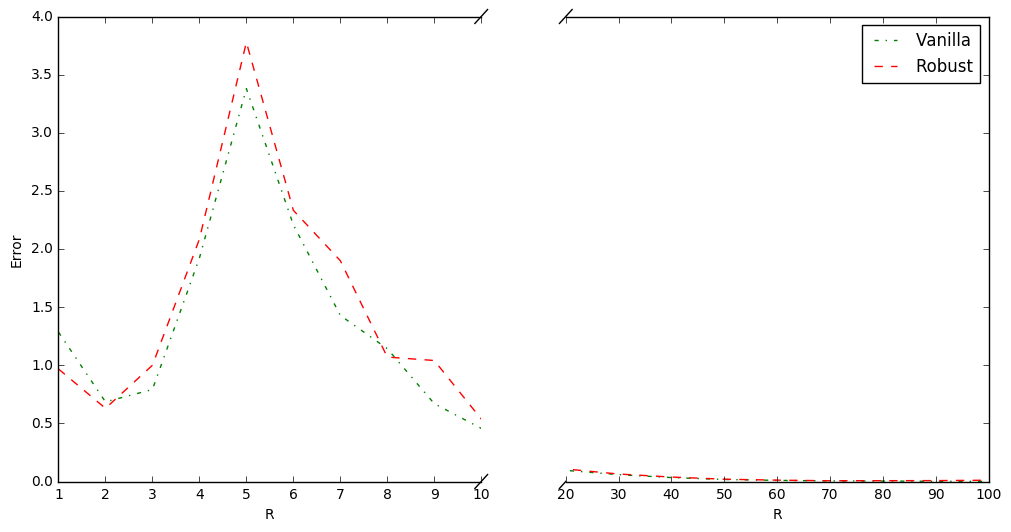

In [5]:
df = pd.DataFrame(rs).transpose()
print(df)

f, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax.plot(df.axes[0], df['Vanilla'], color='g', linestyle='-.')
ax.plot(df.axes[0], df['Robust'], color='r', linestyle='--')
ax2.plot(df.axes[0], df['Vanilla'], color='g', linestyle='-.', label='Vanilla')
ax2.plot(df.axes[0], df['Robust'], color='r', linestyle='--', label='Robust')

ax.set_xlim(1,10)
ax2.set_xlim(20,100)

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.tick_params(labelright='off')

d = 0.015
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Bottom-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Top-left diagonal

kwargs.update(transform=ax2.transAxes)
ax.plot((-d, d), (-d, +d), **kwargs)  # Bottom-right diagonal
ax.plot((-d, d), (1 - d, 1 + d), **kwargs)  # Top-right diagonal

ax.set_ylabel('Error')
ax.set_xlabel('R')
ax2.set_xlabel('R')

plt.legend()

In [6]:
run(100, plot=True)

TypeError: run() missing 3 required positional arguments: 'robust', 'u', and 'y'

In [ ]:
run(.05, plot=True)